# Import

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")


# load dataset

In [3]:
df = pd.read_csv("train.csv")

# Convert Order Date to datetime (dayfirst=True because your dataset looks like dd/mm/yyyy)
df["Order Date"] = pd.to_datetime(df["Order Date"], dayfirst=True, errors="coerce")

# Check if any NaT values remain
print("Null Dates:", df["Order Date"].isna().sum())

# Aggregate sales by day
df = df.groupby(df["Order Date"].dt.date)["Sales"].sum().reset_index()

# Convert back to datetime index
df["Order Date"] = pd.to_datetime(df["Order Date"])
df.set_index("Order Date", inplace=True)

df.head()

Null Dates: 0


,Sales
Order Date,
2015-01-03,16.448
2015-01-04,288.060
2015-01-05,19.536
2015-01-06,4407.100
2015-01-07,87.158


# Visiualization

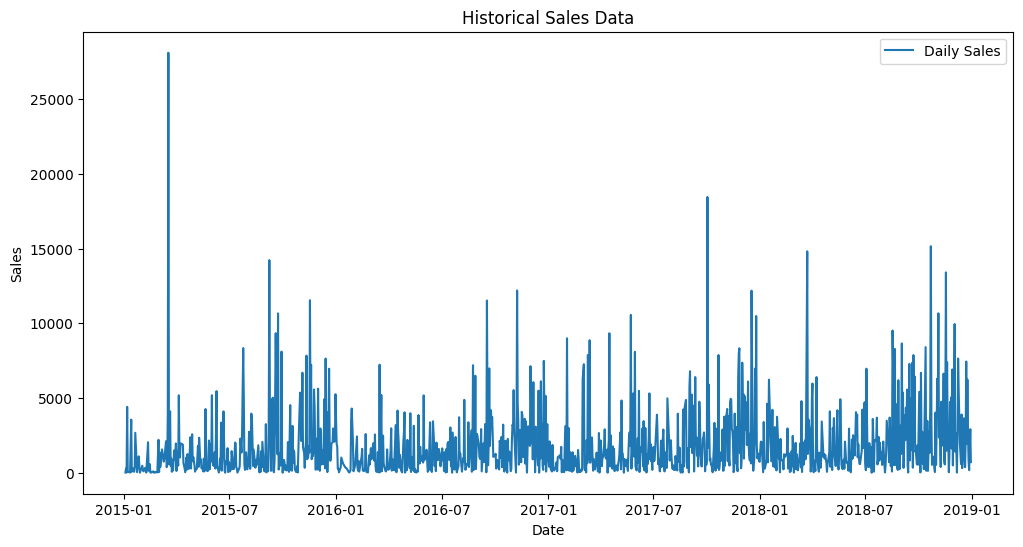

In [4]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df["Sales"], label="Daily Sales")
plt.title("Historical Sales Data")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

# # Train Test Split

In [5]:
# Aggregate weekly sales for smoother series
weekly_sales = df["Sales"].resample("W").sum()

train = weekly_sales.iloc[:-12]   # last 12 weeks test
test = weekly_sales.iloc[-12:]


# Sarima model train

In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# New parameters (tune karna zaroori hai)
model = SARIMAX(train, order=(2,1,2), seasonal_order=(1,1,1,52))
sarima_fit = model.fit(disp=False)

forecast_sarima = sarima_fit.forecast(steps=len(test))


# XGBoost model train

In [7]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Create lag features for supervised learning
df_supervised = pd.DataFrame(weekly_sales)
df_supervised["lag1"] = df_supervised["Sales"].shift(1)
df_supervised["lag2"] = df_supervised["Sales"].shift(2)
df_supervised["lag3"] = df_supervised["Sales"].shift(3)
df_supervised.dropna(inplace=True)

# Train-test split
train_size = int(len(df_supervised) * 0.8)
train_ml = df_supervised.iloc[:train_size]
test_ml = df_supervised.iloc[train_size:]

X_train, y_train = train_ml.drop("Sales", axis=1), train_ml["Sales"]
X_test, y_test = test_ml.drop("Sales", axis=1), test_ml["Sales"]

# Train XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)


# Evaluate Both Model

In [9]:
def evaluate(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true+1e-6))) * 100
    print(f"{name} Results:")
    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"MAPE : {mape:.2f}%")
    print(f"R²   : {r2:.4f}\n")

# Evaluate SARIMA
evaluate(test, forecast_sarima, "SARIMA")

# Evaluate XGBoost
evaluate(y_test, y_pred, "XGBoost")


SARIMA Results:
MAE  : 5559.68
RMSE : 6884.43
MAPE : 26.87%
R²   : 0.0313

XGBoost Results:
MAE  : 5401.98
RMSE : 6723.25
MAPE : 38.67%
R²   : 0.1986



# visiualization

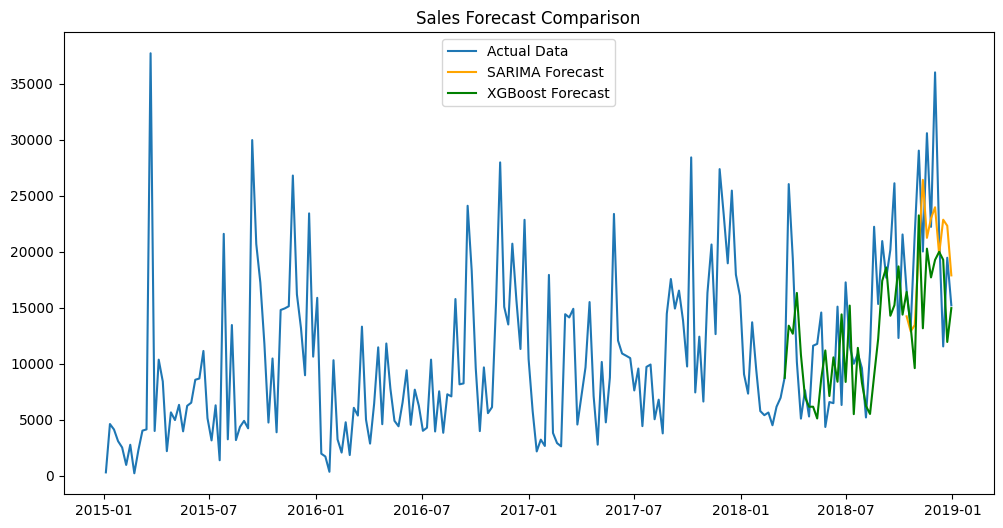

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(weekly_sales.index, weekly_sales, label="Actual Data")
plt.plot(test.index, forecast_sarima, label="SARIMA Forecast", color="orange")
plt.plot(test_ml.index, y_pred, label="XGBoost Forecast", color="green")
plt.legend()
plt.title("Sales Forecast Comparison")
plt.show()


In [13]:
# forecast_hybrid.py

import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ===============================
# Step 1: Load Dataset
# ===============================
df = pd.read_csv("train.csv", parse_dates=["Order Date"])

# Ensure datetime index
df["Order Date"] = pd.to_datetime(df["Order Date"], errors="coerce")
df = df.groupby("Order Date")["Sales"].sum().reset_index()
df = df.set_index("Order Date")
df = df.asfreq("D")   # fill as daily frequency

# Monthly Aggregation
monthly_sales = df["Sales"].resample("M").sum()


# Train-test split (last 6 months as test)
train = monthly_sales.iloc[:-6]
test = monthly_sales.iloc[-6:]

# ===============================
# Step 2: SARIMA Model
# ===============================
sarima_model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_fit = sarima_model.fit(disp=False)
sarima_forecast = sarima_fit.forecast(steps=len(test))

# ===============================
# Step 3: Prophet Model
# ===============================
prophet_df = train.reset_index().rename(columns={"Order Date":"ds","Sales":"y"})
prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
prophet.fit(prophet_df)

future = prophet.make_future_dataframe(periods=len(test), freq="M")
forecast_prophet = prophet.predict(future)
prophet_forecast = forecast_prophet.iloc[-len(test):]["yhat"].values

# ===============================
# Step 4: XGBoost Model
# ===============================
ml_data = pd.DataFrame(monthly_sales)
ml_data["lag1"] = ml_data["Sales"].shift(1)
ml_data["lag2"] = ml_data["Sales"].shift(2)
ml_data["lag3"] = ml_data["Sales"].shift(3)
ml_data.dropna(inplace=True)

train_ml = ml_data.iloc[:-6]
test_ml = ml_data.iloc[-6:]

X_train, y_train = train_ml.drop("Sales", axis=1), train_ml["Sales"]
X_test, y_test = test_ml.drop("Sales", axis=1), test_ml["Sales"]

xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)
xgb_model.fit(X_train, y_train)
xgb_forecast = xgb_model.predict(X_test)

# ===============================
# Step 5: Hybrid Ensemble
# ===============================
final_forecast = (
    0.3 * sarima_forecast.values
    + 0.4 * prophet_forecast
    + 0.3 * xgb_forecast
)

# ===============================
# Step 6: Accuracy Metrics
# ===============================
mae = mean_absolute_error(test, final_forecast)
rmse = np.sqrt(mean_squared_error(test, final_forecast))
r2 = r2_score(test, final_forecast)
mape = np.mean(np.abs((test.values - final_forecast) / (test.values + 1e-6))) * 100

print("Hybrid Model Accuracy:")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")
print(f"R²   : {r2:.4f}")


15:13:03 - cmdstanpy - INFO - Chain [1] start processing
15:13:04 - cmdstanpy - INFO - Chain [1] done processing


Hybrid Model Accuracy:
MAE  : 4277.21
RMSE : 4893.61
MAPE : 20.84%
R²   : -0.4506


In [16]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ===============================
# Load dataset
# ===============================
df = pd.read_csv("train.csv", parse_dates=["Order Date"])
df["Order Date"] = pd.to_datetime(df["Order Date"], errors="coerce")
df = df.groupby("Order Date")["Sales"].sum().reset_index()
df = df.set_index("Order Date").asfreq("D", fill_value=0)

# ===============================
# Feature Engineering
# ===============================
ml_data = pd.DataFrame(df["Sales"])

# Lag features
for lag in range(1, 13):   # last 12 days as features
    ml_data[f"lag{lag}"] = ml_data["Sales"].shift(lag)

# Rolling features
ml_data["rolling7"] = ml_data["Sales"].rolling(7).mean()
ml_data["rolling30"] = ml_data["Sales"].rolling(30).mean()

# Date features
ml_data["month"] = ml_data.index.month
ml_data["dayofweek"] = ml_data.index.dayofweek
ml_data["quarter"] = ml_data.index.quarter

ml_data.dropna(inplace=True)

# ===============================
# Train-test split
# ===============================
train_size = int(len(ml_data) * 0.8)
train, test = ml_data.iloc[:train_size], ml_data.iloc[train_size:]

X_train, y_train = train.drop("Sales", axis=1), train["Sales"]
X_test, y_test = test.drop("Sales", axis=1), test["Sales"]

# ===============================
# XGBoost model
# ===============================
xgb_model = xgb.XGBRegressor(
    n_estimators=1500,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# ===============================
# LightGBM model
# ===============================
lgb_model = lgb.LGBMRegressor(
    n_estimators=1500,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)
lgb_model.fit(X_train, y_train)

# ===============================
# Forecast (Blend)
# ===============================
xgb_pred_train = xgb_model.predict(X_train)
lgb_pred_train = lgb_model.predict(X_train)
y_pred_train = (xgb_pred_train + lgb_pred_train) / 2

xgb_pred_test = xgb_model.predict(X_test)
lgb_pred_test = lgb_model.predict(X_test)
y_pred_test = (xgb_pred_test + lgb_pred_test) / 2

# ===============================
# Metrics
# ===============================
# Train metrics
train_mae = mean_absolute_error(y_train, y_pred_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
train_r2 = r2_score(y_train, y_pred_train)

# Test metrics
test_mae = mean_absolute_error(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_r2 = r2_score(y_test, y_pred_test)
test_mape = np.mean(np.abs((y_test.values - y_pred_test) / (y_test.values + 1e-6))) * 100

# ===============================
# Print Results
# ===============================
print("===== Train Metrics =====")
print(f"MAE  : {train_mae:.2f}")
print(f"RMSE : {train_rmse:.2f}")
print(f"R²   : {train_r2:.4f}")

print("\n===== Test Metrics =====")
print(f"MAE  : {test_mae:.2f}")
print(f"RMSE : {test_rmse:.2f}")
print(f"MAPE : {test_mape:.2f}%")
print(f"R²   : {test_r2:.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1964
[LightGBM] [Info] Number of data points in the train set: 1128, number of used features: 17
[LightGBM] [Info] Start training from score 580.594076
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

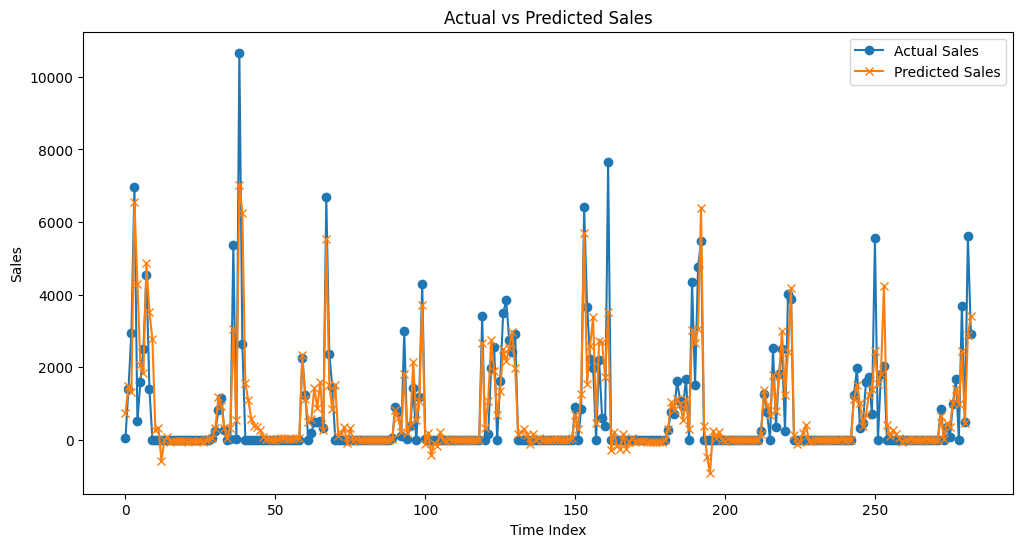

In [17]:
import matplotlib.pyplot as plt

# Compare actual vs predicted (Test set)
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual Sales", marker='o')
plt.plot(y_pred_test, label="Predicted Sales", marker='x')
plt.title("Actual vs Predicted Sales")
plt.xlabel("Time Index")
plt.ylabel("Sales")
plt.legend()
plt.show()


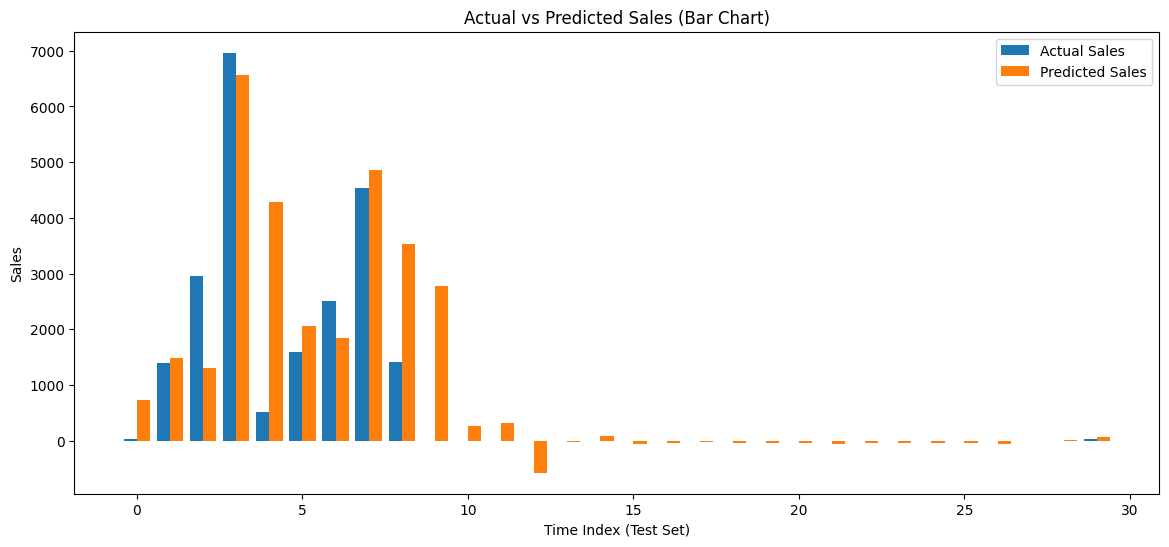

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# First N points compare (jitna chaho utna dekh lo)
N = 30   # Pehle 30 din ka comparison
actual = y_test.values[:N]
predicted = y_pred_test[:N]

x = np.arange(N)  # X-axis index

plt.figure(figsize=(14,6))
plt.bar(x - 0.2, actual, width=0.4, label="Actual Sales")
plt.bar(x + 0.2, predicted, width=0.4, label="Predicted Sales")

plt.title("Actual vs Predicted Sales (Bar Chart)")
plt.xlabel("Time Index (Test Set)")
plt.ylabel("Sales")
plt.legend()
plt.show()
